In [59]:
import pandas as pd
user=pd.read_parquet('all_user.parquet')
repository=pd.read_parquet('all_repository.parquet')
#user.head()
repository.head()

,id,url,license,full_name,language,forks,stars
0,987641962,https://api.github.com/repos/1010-dev/senjudev...,None,1010-dev/senjudev-site,TypeScript,1.0,0.0
1,990249393,https://api.github.com/repos/106-/HellSinkerWa...,None,106-/HellSinkerWallPaper,Java,0.0,0.0
2,1009549206,https://api.github.com/repos/1genadam/tileshop...,None,1genadam/tileshop-rag,Python,0.0,0.0
3,983546765,https://api.github.com/repos/1kimnet/ETL-pipeline,None,1kimnet/ETL-pipeline,Python,0.0,0.0
4,1024190983,https://api.github.com/repos/20m61/lightningta...,None,20m61/lightningtalk-circle,JavaScript,0.0,0.0


In [43]:
top5language = repository['language'].value_counts().head(5).index.tolist()
print(f'top 5 popular language is :{top5language}')
repository_filter=repository[repository['language'].isin(top5language)].copy()
#repository_filter.info()
#the number of respository group by userId
repository_count = repository_filter.groupby(['id', 'language']).size().reset_index(name='repository_count')
repository_filter['owner_login'] = repository_filter['full_name'].str.split('/').str[0]
data = pd.merge(
    
    repository_filter, user, 
    left_on='owner_login', 
    right_on='login', 
    how='inner'  
)
print(data[['full_name','owner_login', 'login', 'followers', 'language']].head())

top 5 popular language is :['Python', 'TypeScript', 'JavaScript', 'HTML', 'Java']
                    full_name owner_login     login  followers    language
0    106-/HellSinkerWallPaper        106-      106-        6.0        Java
1       1genadam/tileshop-rag    1genadam  1genadam        0.0      Python
2        1kimnet/ETL-pipeline     1kimnet   1kimnet        0.0      Python
3  20m61/lightningtalk-circle       20m61     20m61        7.0  JavaScript
4     20m61/my-gen-ai-usecase       20m61     20m61        7.0  TypeScript


In [45]:
user_stats = data.groupby(['owner_login', 'language']).agg({
    'id_x': 'count', 'followers': 'first'     
}).reset_index()
user_stats.rename(columns={'id_x': 'repository_count'}, inplace=True)

print(user_stats.head())
results = []
for lang in top5language:
    subset = user_stats[user_stats['language'] == lang]
    if len(subset) > 1:
        corr = subset['repository_count'].corr(subset['followers'], method='spearman')
        results.append({
            'Language': lang,
            'Spearman_Correlation': round(corr, 4), 
            'Sample_Size': len(subset)
        })

results_df = pd.DataFrame(results)
print(results_df)

    owner_login    language  repository_count  followers
0    000Sean000      Python                 1        0.0
1       000alen  TypeScript                 1       46.0
2      00125495      Python                 1        0.0
3  001priyanshi        HTML                 1        0.0
4       001vamp  TypeScript                 1        1.0
     Language  Spearman_Correlation  Sample_Size
0      Python                0.0252        17296
1  TypeScript                0.0331        12161
2  JavaScript               -0.0111        10877
3        HTML               -0.0152         8041
4        Java                0.0340         2323


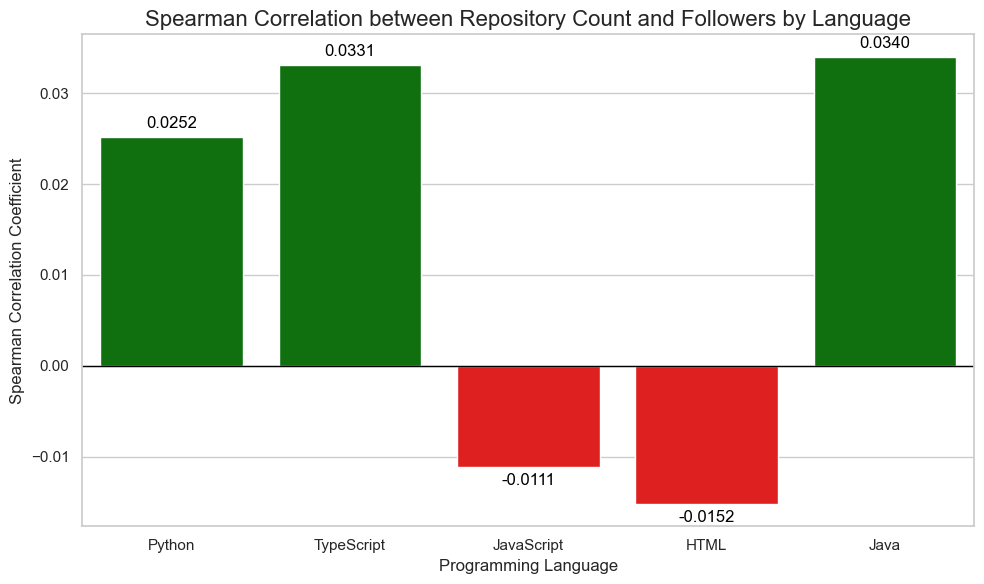

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'Language': ['Python', 'TypeScript', 'JavaScript', 'HTML', 'Java'],
    'Spearman_Correlation': [0.0252, 0.0331, -0.0111, -0.0152, 0.0340]
}
df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

colors = ['green' if x > 0 else 'red' for x in df['Spearman_Correlation']]
sns.barplot(x='Language', y='Spearman_Correlation', hue='Language', data=df, palette=colors, legend=False)

plt.axhline(0, color='black', linewidth=1)
plt.title('Spearman Correlation between Repository Count and Followers by Language', fontsize=16)
plt.xlabel('Programming Language', fontsize=12)
plt.ylabel('Spearman Correlation Coefficient', fontsize=12)

for i, v in enumerate(df['Spearman_Correlation']):
    offset = 0.001 if v > 0 else -0.002
    plt.text(i, v + offset, f"{v:.4f}", color='black', ha="center")

plt.tight_layout()
plt.savefig('spearman_correlation_chart.png')

summary:

Slight Positive Trend: Java (0.0340), TypeScript (0.0331), and Python (0.0252) show a tiny positive correlation. This suggests a very marginal tendency where users with more repositories might have slightly more followers, but the effect is statistically insignificant.

Slight Negative Trend: JavaScript (-0.0111) and HTML (-0.0152) show a tiny negative correlation. This indicates that for web-focused languages, simply creating more repositories has no positive impact on gaining followers.

In [56]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

user['created_at'] = pd.to_datetime(user['created_at'], utc=True)
ref_date = pd.Timestamp.now(tz='UTC')
user['account_age_days'] = (ref_date - user['created_at']).dt.days

repository['owner_login'] = repository['full_name'].str.split('/').str[0]

def get_main_language(series):
    mode = series.mode()
    if not mode.empty:
        return mode[0] 
    return 'Unknown'

user_repo_stats = repository.groupby('owner_login').agg({
    'id': 'count',
    'language': get_main_language
}).reset_index().rename(columns={'id': 'repo_count', 'language': 'main_language'})

df_analysis = pd.merge(
    user[['login', 'followers', 'account_age_days']], 
    user_repo_stats,
    left_on='login',
    right_on='owner_login',
    how='inner'
)

df_analysis['main_language'] = df_analysis['main_language'].fillna('Unknown')
df_analysis = df_analysis.dropna()

top_10_langs = df_analysis['main_language'].value_counts().head(10).index
df_analysis['language_group'] = df_analysis['main_language'].apply(
    lambda x: x if x in top_10_langs else 'Other'
)

df_encoded = pd.get_dummies(df_analysis, columns=['language_group'], drop_first=True)

lang_features = [col for col in df_encoded.columns if 'language_group_' in col]
feature_cols = ['account_age_days', 'repo_count'] + lang_features

X = df_encoded[feature_cols]
y = df_encoded['followers']

if X.isnull().values.any():
    X = X.fillna(0)

model = LinearRegression()
model.fit(X, y)

coefficients = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

final_report_view = coefficients[
    ~coefficients['Feature'].str.contains('Other') & 
    ~coefficients['Feature'].str.contains('Unknown')
]

print(final_report_view)

                            Feature  Coefficient
4               language_group_Java     4.273766
1                        repo_count     3.728422
10        language_group_TypeScript     3.210270
0                  account_age_days     0.013978
5         language_group_JavaScript    -1.472866
6   language_group_Jupyter Notebook    -2.304943
9             language_group_Python    -4.242792
2                language_group_C++    -5.265266
3               language_group_HTML    -6.357758
8                language_group_PHP   -13.747330


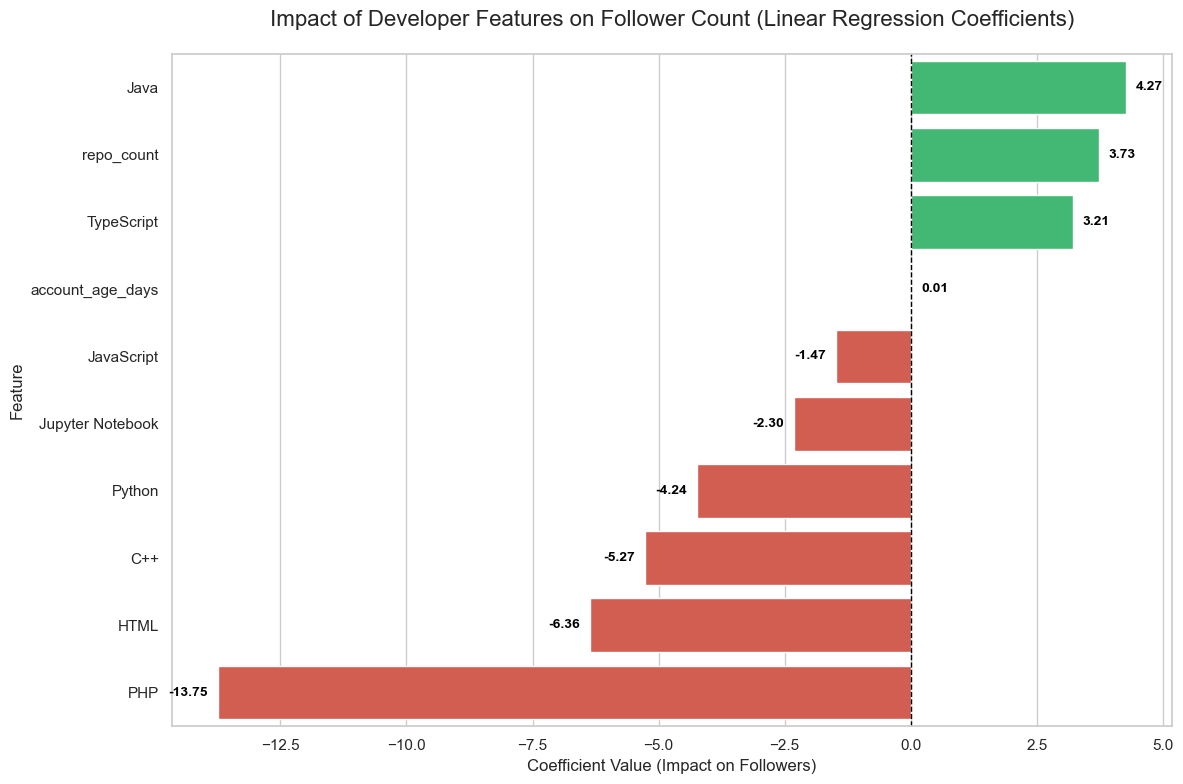

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'Feature': [
        'language_group_Java', 'repo_count', 'language_group_TypeScript',
        'account_age_days', 'language_group_JavaScript', 'language_group_Jupyter Notebook',
        'language_group_Python', 'language_group_C++', 'language_group_HTML',
        'language_group_PHP'
    ],
    'Coefficient': [
        4.273789, 3.728423, 3.210295, 0.013978, -1.472838,
        -2.304913, -4.242757, -5.265245, -6.357725, -13.747307
    ]
}
df = pd.DataFrame(data)
df['Feature_Clean'] = df['Feature'].str.replace('language_group_', '')
df = df.sort_values(by='Coefficient', ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in df['Coefficient']]
sns.barplot(x='Coefficient', y='Feature_Clean', data=df, palette=colors, hue='Feature_Clean', legend=False)

plt.title('Impact of Developer Features on Follower Count (Linear Regression Coefficients)', fontsize=16, pad=20)
plt.xlabel('Coefficient Value (Impact on Followers)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(0, color='black', linewidth=1, linestyle='--')

for i, v in enumerate(df['Coefficient']):
    offset = 0.2 if v > 0 else -0.2
    ha = 'left' if v > 0 else 'right'
    plt.text(v + offset, i, f'{v:.2f}', va='center', ha=ha, fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.savefig('rq2_coefficients_chart.png')

Although repo_count (repository count) is positively correlated, the choice of programming language (e.g., Java vs. PHP) appears to have a greater magnitude of impact on follower count. Meanwhile, account_age_days (account tenure), while positive, has a very minimal impact (close to 0).

In [58]:
issue=pd.read_parquet('issue.parquet')
issue.head()

,id,number,title,body,user,state,created_at,closed_at,html_url
0,3082498013,1542,Accept api_key in from_provider,**Is your feature request related to a problem...,jeroenvds,closed,2025-05-22T08:22:22Z,2025-07-17T22:34:21Z,https://github.com/567-labs/instructor/issues/...
1,3164229012,94,Workflows Coming Soon - tools reimagined,### Project Version\n\n5.5.0\n\n### Bug Descri...,guidedways,closed,2025-06-20T19:42:16Z,2025-06-20T20:08:12Z,https://github.com/BeehiveInnovations/zen-mcp-...
2,3198054361,107,[bug]PromptX工具沙箱缓存机制不支持工具集更新,"当工具集需要改进的时候, 会遇到改进后代码和沙箱中的代码不一致的情况.对鲁班自己调试代码造成...",simonfishgit,closed,2025-07-03T05:20:38Z,2025-07-10T01:44:56Z,https://github.com/Deepractice/PromptX/issues/107
3,3208181218,129,架构优化：统一项目路径管理体系 - 合并DirectoryService与ProjectMa...,# 🎯 架构优化：统一项目路径管理体系\n\n## 🔍 问题描述\n\n当前PromptX在...,deepracticexs,closed,2025-07-07T09:12:24Z,2025-07-07T11:05:45Z,https://github.com/Deepractice/PromptX/issues/129
4,2975033421,836,Broken links to notebooks in documentation,On [this documentation page](https://incatools...,justaddcoffee,closed,2025-04-06T15:46:33Z,2025-06-05T23:32:27Z,https://github.com/INCATools/ontology-access-k...


In [63]:
comments_df=pd.read_parquet('pr_comments.parquet')
comments_df.head()

,id,pr_id,user,user_id,user_type,created_at,body
0,2927293042,3107321792,coderabbitai[bot],136622811,Bot,2025-06-01T14:15:35Z,<!-- This is an auto-generated comment: summar...
1,3090154270,3234660269,Fank,1900106,User,2025-07-18T17:22:34Z,"claude budget reached, development is on hold ..."
2,2848667986,3037457814,wilsonccccc,6146503,User,2025-05-03T15:12:37Z,"Hi, thanks for sharing and contributing! Pleas..."
3,2719183506,2915198291,cloudflare-workers-and-pages[bot],73139402,Bot,2025-03-12T21:34:46Z,## Deploying instructor-py with &nbsp;<a href=...
4,3013998830,3132410695,razimantv,3823215,User,2025-06-27T18:16:05Z,Can you rebase it to the current master? Pleas...


Median comment count: 5.0
T-statistic: -1.0410
P-value: 2.9818e-01
Conclusion: No significant difference in TTR between groups


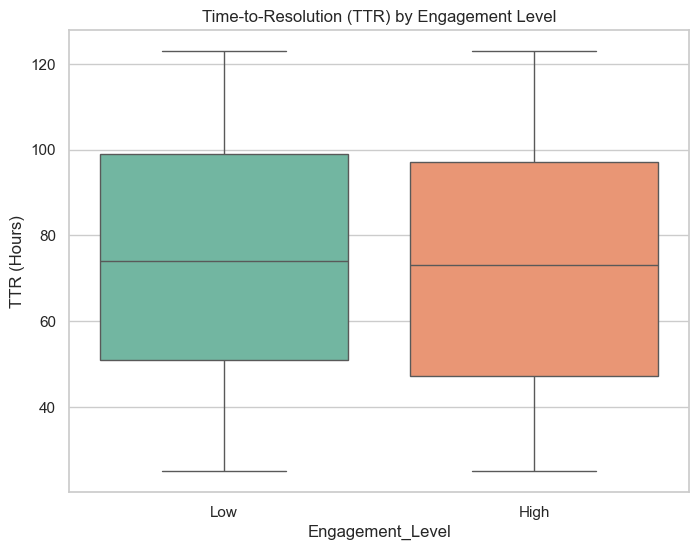

In [82]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


#comment_counts = comments_df.groupby('pr_id').size().reset_index(name='comment_count')

#issues = pd.merge(issues, comment_counts, left_on='id', right_on='pr_id', how='left')
#issues['comment_count'] = issues['comment_count'].fillna(0)

issues['created_at'] = pd.to_datetime(issues['created_at'], utc=True)
issues['closed_at'] = pd.to_datetime(issues['closed_at'], utc=True)

issues_closed = issues.dropna(subset=['closed_at']).copy()

issues_closed['TTR_hours'] = (issues_closed['closed_at'] - issues_closed['created_at']).dt.total_seconds() / 3600
issues_closed = issues_closed[issues_closed['TTR_hours'] > 0]

median_comments = issues_closed['comment_count'].median()

issues_closed['Engagement_Level'] = issues_closed['comment_count'].apply(
    lambda x: 'High' if x > median_comments else 'Low'
)

high_group = issues_closed[issues_closed['Engagement_Level'] == 'High']['TTR_hours']
low_group = issues_closed[issues_closed['Engagement_Level'] == 'Low']['TTR_hours']

t_stat, p_value = stats.ttest_ind(high_group, low_group, equal_var=False)

print(f"Median comment count: {median_comments}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")

if p_value < 0.05:
    print("Conclusion: Significant difference in TTR between groups (Reject Null Hypothesis)")
else:
    print("Conclusion: No significant difference in TTR between groups")

plt.figure(figsize=(8, 6))
sns.boxplot(x='Engagement_Level', y='TTR_hours', data=issues_closed, hue='Engagement_Level', palette='Set2', legend=False)
plt.title('Time-to-Resolution (TTR) by Engagement Level')
plt.ylabel('TTR (Hours)')
plt.show()

Contrary to expectations, engagement level (measured by comment count) was not found to be a significant predictor of time-to-resolution (t(df) = -1.04, p = 0.30).